# Project: European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This project uses an SQLite based database containing data about 11 European Countries with their lead championship, +10,000 players, +25,000 matches, and Players and Teams' attributes sourced from EA Sports' FIFA video game series, including the weekly updates. This data was obtained from Kaggle website: https://www.kaggle.com/hugomathien/soccer?select=database.sqlite
>


### Question(s) for Analysis
> In this project, we will answer the following questions:
>> What Season has the most scored goals over the time period?
>>
>> Which teams scored the most home goals and away goals over the time period?
>>
>> Which players had the most penalties?
>>
>> In what percentage does the field affect the result?

> First, import the packages that will be used throughout the project

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
from bs4 import BeautifulSoup

<a id='wrangling'></a>
## Data Wrangling

> In this section of the report, we will load in the data, check for cleanliness, and then trim and clean the dataset for analysis.

### General Properties

In [150]:
# Load the data from the dataset
con = sqlite3.connect("database.sqlite")

df_coun = pd.read_sql_query("SELECT * from Country", con)
# Verify that result of SQL query is stored in the dataframe
df_coun.head(2)
    

,id,name
0,1,Belgium
1,1729,England


In [151]:
df_leag = pd.read_sql_query("SELECT * from League", con)
df_leag.head(2)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League


In [152]:
df_match = pd.read_sql_query("SELECT * from Match", con)
df_match.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


In [153]:
df_player = pd.read_sql_query("SELECT * from Player", con)
df_player.head(2)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146


In [154]:
df_player_attr = pd.read_sql_query("SELECT * from Player_Attributes", con)
df_player_attr.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [155]:
df_team = pd.read_sql_query("SELECT * from Team", con)
df_team.head(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC


In [156]:
df_team_attr = pd.read_sql_query("SELECT * from Team_Attributes", con)
df_team_attr.head(2)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover


> #### Merge the dataframes into one dataframe

>Merge the match dataframe with team info

In [157]:
df_match_merg = df_match.merge(df_team[['team_api_id', 'team_long_name']], left_on = 'home_team_api_id',
                                      right_on = 'team_api_id', how = 'left', suffixes = ('_match', '_team'))
df_match_merg.rename(columns = {'team_api_id': 'team_api_id_home', 'team_long_name': 'home_team'}, inplace = True)
df_match_merg = df_match_merg.merge(df_team[['team_api_id', 'team_long_name']], left_on = 'away_team_api_id',
                                      right_on = 'team_api_id', how = 'left', suffixes = ('_match','_away'))
df_match_merg.rename(columns = {'team_api_id': 'team_api_id_home', 'team_long_name': 'away_team'}, inplace = True)

>Merge the match dataframe with country info

In [158]:
df_match_merg = df_match_merg.merge(df_coun, left_on = 'country_id', right_on = 'id', how = 'left', suffixes = ('_match', '_country'))
df_match_merg.rename(columns = {'name': 'country'}, inplace = True)


>Merge the match dataframe with league info

In [159]:
df_match_merg = df_match_merg.merge(df_leag, left_on = 'league_id', right_on = 'id', how = 'left', suffixes = ('_match', '_league'))
df_match_merg.rename(columns = {'id': 'id_league', 'name':'league'}, inplace = True)

>Create a goals in match column

In [160]:
df_match_merg['total_goals'] = df_match_merg['home_team_goal'] + df_match_merg['away_team_goal']

>Change the type of the date column into datetime

In [161]:
df_match_merg['date'] = pd.to_datetime(df_match_merg['date'])


>Create a winning team column stating the match winning team using dataframe.loc 

In [162]:
df_match_merg.loc[df_match_merg['home_team_goal'] > df_match_merg['away_team_goal'], 'winning_team'] = df_match_merg['home_team']
df_match_merg.loc[df_match_merg['away_team_goal'] > df_match_merg['home_team_goal'], 'winning_team'] = df_match_merg['away_team']
# in case of draw
df_match_merg.loc[df_match_merg['home_team_goal'] == df_match_merg['away_team_goal'], 'winning_team'] = np.nan

>The same for the match losing team

In [163]:
df_match_merg.loc[df_match_merg['home_team_goal'] > df_match_merg['away_team_goal'], 'losing_team'] = df_match_merg['away_team']
df_match_merg.loc[df_match_merg['away_team_goal'] > df_match_merg['home_team_goal'], 'losing_team'] = df_match_merg['home_team']
# in case of draw
df_match_merg.loc[df_match_merg['home_team_goal'] == df_match_merg['away_team_goal'], 'losing_team'] = np.nan

>Create a result column for to indicate the winner of the match (HW: home win, AW: away win, D: draw)

In [164]:
df_match_merg.loc[df_match_merg['home_team_goal'] > df_match_merg['away_team_goal'], 'result'] = 'HW'
df_match_merg.loc[df_match_merg['away_team_goal'] > df_match_merg['home_team_goal'], 'result'] = 'AW'
df_match_merg.loc[df_match_merg['home_team_goal'] == df_match_merg['away_team_goal'], 'result'] = 'D'

In [165]:
df_match_merg.head(2)

,id_match,country_id_match,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_team,id_country,country,id_league,country_id_league,league,total_goals,winning_team,losing_team,result
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,Beerschot AC,1,Belgium,1,1,Belgium Jupiler League,2,NaN,NaN,D
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,Sporting Lokeren,1,Belgium,1,1,Belgium Jupiler League,0,NaN,NaN,D


### Data Cleaning 

> Select the desired columns from the merged match dataframe and insert them into a new dataframe to analyse

In [166]:
df_match_v2 = df_match_merg[['season', 'stage', 'date', 'country', 'league', 'home_team', 'away_team', 'home_team_goal',
                             'away_team_goal', 'total_goals', 'winning_team','losing_team', 'result']]
df_match_v2.head()

,season,stage,date,country,league,home_team,away_team,home_team_goal,away_team_goal,total_goals,winning_team,losing_team,result
0,2008/2009,1,2008-08-17,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC,1,1,2,NaN,NaN,D
1,2008/2009,1,2008-08-16,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren,0,0,0,NaN,NaN,D
2,2008/2009,1,2008-08-16,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht,0,3,3,RSC Anderlecht,KSV Cercle Brugge,AW
3,2008/2009,1,2008-08-17,Belgium,Belgium Jupiler League,KAA Gent,RAEC Mons,5,0,5,KAA Gent,RAEC Mons,HW
4,2008/2009,1,2008-08-16,Belgium,Belgium Jupiler League,FCV Dender EH,Standard de Liège,1,3,4,Standard de Liège,FCV Dender EH,AW


<a id='eda'></a>
## Exploratory Data Analysis

### What Season has the most scored goals over the time period?

> Insert the scored goals per season in a new dataframe

In [167]:
df_season_goal = df_match_v2.groupby(['season']).sum().sort_values(['season'], ascending = True).reset_index()
df_season_goal

,season,stage,home_team_goal,away_team_goal,total_goals
0,2008/2009,60921,5007,3665,8672
1,2009/2010,58821,4978,3654,8632
2,2010/2011,59286,5048,3701,8749
3,2011/2012,58203,5064,3683,8747
4,2012/2013,59286,5053,3986,9039
5,2013/2014,55608,4787,3602,8389
6,2014/2015,60883,5055,3842,8897
7,2015/2016,60921,5135,4027,9162


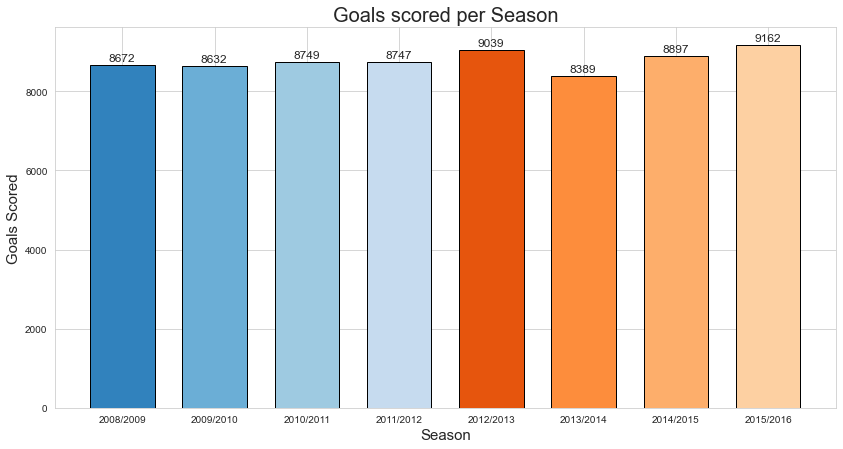

In [168]:
plt.figure(figsize=[14, 7])
col_map = plt.get_cmap('tab20c')


pl = plt.bar(df_season_goal.season, df_season_goal.total_goals, width = 0.7, color = col_map.colors, 
        edgecolor='k', linewidth = 1)

for bar in pl:
    plt.annotate(bar.get_height(), 
                 xy=(bar.get_x() + 0.2, bar.get_height() + 100), 
                     fontsize = 12)

plt.ylabel('Goals Scored', fontsize = 15)
plt.xlabel('Season', fontsize = 15)
plt.title('Goals scored per Season', fontsize = 20)
plt.show()

### Which teams has the most home goals and away goals over the time period?

> Most home goals scoring teams

In [169]:
df_team_hg = df_match_v2.groupby(['home_team']).sum().sort_values(['home_team_goal'], ascending = False).reset_index()
df_team_hg

,home_team,stage,home_team_goal,away_team_goal,total_goals
0,Real Madrid CF,2983,505,147,652
1,FC Barcelona,2964,495,101,596
2,Celtic,2936,389,88,477
3,FC Bayern Munich,2329,382,96,478
4,PSV,2375,370,126,496
...,...,...,...,...,...
291,Trofense,225,14,21,35
292,AC Arles-Avignon,372,14,31,45
293,Feirense,225,13,19,32
294,Córdoba CF,361,12,33,45


> Plot the first five teams

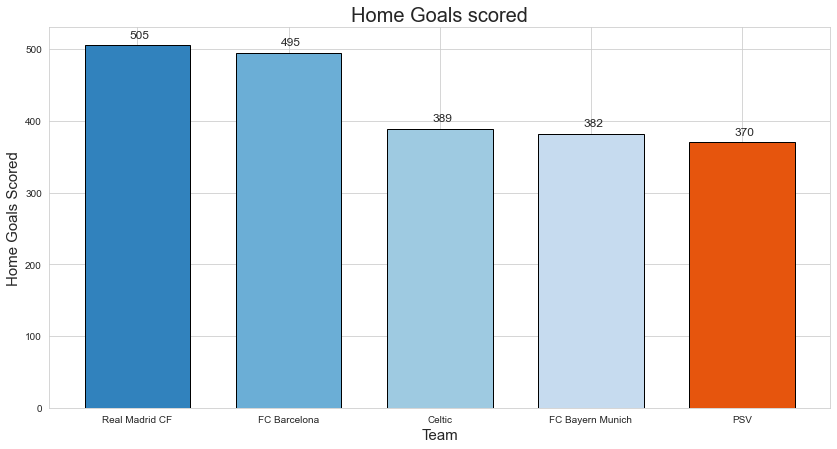

In [170]:
plt.figure(figsize=[14, 7])
col_map = plt.get_cmap('tab20c')


pl = plt.bar(df_team_hg.home_team[0:5], df_team_hg.home_team_goal[0:5], width = 0.7, color = col_map.colors, 
        edgecolor = 'k', linewidth = 1)

for bar in pl:
    plt.annotate(bar.get_height(), 
                 xy=(bar.get_x() + 0.3, bar.get_height() + 10), 
                     fontsize = 12)

plt.ylabel('Home Goals Scored', fontsize = 15)
plt.xlabel('Team', fontsize = 15)
plt.title('Home Goals scored', fontsize = 20)
plt.show()

> Most away goals scoring teams

In [171]:
df_team_ag = df_match_v2.groupby(['away_team']).sum().sort_values(['away_team_goal'], ascending = False).reset_index()
df_team_ag

,away_team,stage,home_team_goal,away_team_goal,total_goals
0,FC Barcelona,2964,131,354,485
1,Real Madrid CF,2945,157,338,495
2,Celtic,2992,135,306,441
3,Ajax,2372,158,287,445
4,PSV,2385,168,282,450
...,...,...,...,...,...
291,Hércules Club de Fútbol,361,33,9,42
292,Uniao da Madeira,306,33,8,41
293,AC Arles-Avignon,369,39,7,46
294,Reggio Calabria,361,35,7,42


> Plot the first five teams

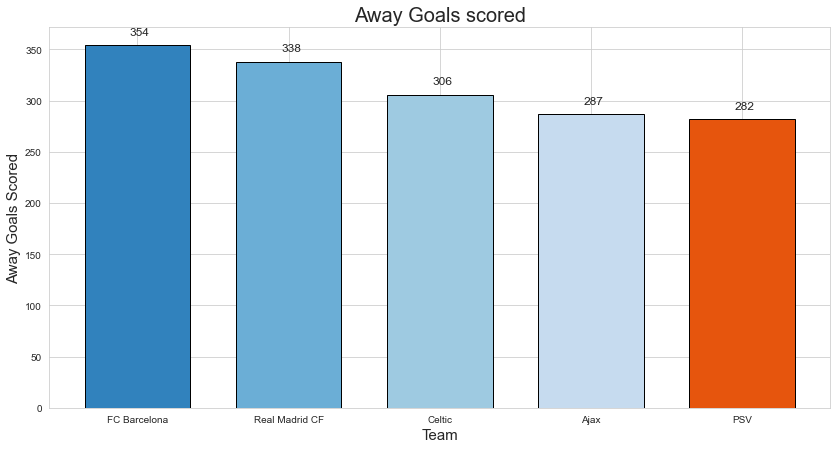

In [172]:
plt.figure(figsize=[14, 7])
col_map = plt.get_cmap('tab20c')


pl = plt.bar(df_team_ag.away_team[0:5], df_team_ag.away_team_goal[0:5], width = 0.7, color = col_map.colors, 
        edgecolor = 'k', linewidth = 1)

for bar in pl:
    plt.annotate(bar.get_height(), 
                 xy=(bar.get_x() + 0.3, bar.get_height() + 10), 
                     fontsize = 12)

plt.ylabel('Away Goals Scored', fontsize = 15)
plt.xlabel('Team', fontsize = 15)
plt.title('Away Goals scored', fontsize = 20)
plt.show()

### Which players had the most penalties?

Define an empty list to which the penalty scorers will be appended 

In [173]:
pen_list = []

Drop the rows with null goal cells 

In [174]:
df_g = df_match[df_match['goal'].notna()]

>Loop over each match and append the player to pen_list if a penalty was scored

In [175]:
for index, row in df_g.iterrows():
    soup = BeautifulSoup(df_g.goal[index],'lxml') 
    hamada = soup.find_all('penalties')
    if hamada: 
        for i in soup.penalties:
            pen_goal = soup.penalties
            pen_player_id = pen_goal.find_next("player1").text
            pen_list.append({'pen_player_id': pen_player_id })

In [176]:
df_pen_player = pd.DataFrame(pen_list, columns = ['pen_player_id'])

>Display the list of most players to score penalties descendingly

In [177]:
df_pen_player.value_counts()

pen_player_id
30893            47
35724            37
30981            31
27734            25
30714            23
                 ..
37154             1
243163            1
36774             1
36623             1
101041            1
Length: 772, dtype: int64

In [178]:
idx = int(df_pen_player['pen_player_id'].mode()[0])
idx

30893

In [179]:
m = df_player.player_name[df_player['player_api_id'] == idx].to_string(index=False)
print('The most penalties scorer over the time period is: {}'.format(m))


The most penalties scorer over the time period is: Cristiano Ronaldo


### In what percentage does the field affect the result?

> Create a dataframe to store the percentage of every result

In [180]:
df_win_percent = pd.DataFrame({
    'Home Wins': [len(df_match_v2[df_match_v2['result'] == 'HW']) / len(df_match_v2)*100],
    'Away Wins': [len(df_match_v2[df_match_v2['result'] == 'AW']) / len(df_match_v2)*100],
    'Draw': [len(df_match_v2[df_match_v2['result'] == 'D']) / len(df_match_v2)*100]})

> Specify the plot specs 

<Figure size 432x432 with 0 Axes>

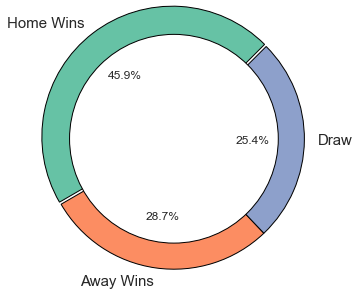

In [181]:
plt.figure(figsize = (6,6))
plt.figure(facecolor='white')
patches, text, autotext = plt.pie(df_win_percent.iloc[0], labels = df_win_percent.columns, startangle = 45, autopct = '%1.1f%%',
                              explode = (0.03, 0, 0), radius = 1.5, colors = sns.color_palette("Set2"), 
                              wedgeprops = {'edgecolor':'k'})

for  x in text:
    x.set_fontsize(15)
for y in autotext:
    y.set_fontsize(12)

    
centre_circle = plt.Circle((0,0), 1.2, fc='white', edgecolor = 'k')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

>Lastly, close the connection

In [182]:
con.close()

<a id='conclusions'></a>
## Conclusions

> The previous analyses showed that, 2015/2016 season was the season in which the most goals were scored, Real Madrid CF and FC Barcelona were dominating goal scoaring in both the home and away games over the spcified period, Cristiano Ronaldo was the most player scoring goals from penalties, over the spcified period, and finally, the pie chart impliesthat it is most likely to win the game if team is playing on its field.
>
> Some of the limitations that the project was facing are, the lack of context and data in some rows in the match database. columns such as goal, card, and other column given in html format, beside the html text was not written a tradional formmat, lack context to the variable within.